<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center", style="margin-bottom: -10px">Определение возраста покупателей<a class="tocSkip"></h1>
<h4 align="center", style="margin-bottom: 60px">Учебный проект №14, Яндекс Практикум <a class="tocSkip"> </h4>
<h4 align="right", style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<p style="margin-bottom: 30px"></p>
<h2>Задача:<span class="tocSkip"></span></h2>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

<p style="margin-bottom: 30px"></p>
<h2> Описание данных:  <span class="tocSkip"></span></h2>

В нашем распоряжении набор фотографий людей с указанием возраста. 
Данные взяты с сайта <a href = "https://chalearnlap.cvc.uab.cat/dataset/26/description/">ChaLearn Looking at People</a>.

Данные состоят из двух папок - одна папка со всеми изображениями `/final_files` и CSV-файл `labels.csv` с двумя колонками: *file_name* и *real_age*.  

# 0 Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

# 1 Загрузка данных

## 1.1 Загрузка изображений

In [4]:
datagen = ImageDataGenerator(rescale=1/255.) 

datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',       # папка, в которой хранится датасет
    target_size=(224, 224),   # к какому размеру приводить изображения
    batch_size=32,            # размер батча
    class_mode='sparse',      # в каком виде выдавать метки классов
    shuffle=False,            
    seed=12345)               # генератор случайных чисел


features, target = next(datagen_flow)

Found 7591 images belonging to 1 classes.


**Вывод:** Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации

## 1.2 Загрузка датасета

In [2]:
# функция загрузки данных

def csv_load(name):
    
    data = None
    try:
        data = pd.read_csv(f'/datasets/faces/{name}.csv')  
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/faces/{name}.csv')
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')
            
    return data

In [3]:
data = csv_load('labels')

**Вывод:** Данные успешно загружены, ошибок в файле и датасете нет.

# 2 Предварительный обзор данных

## 2.1 Изображения

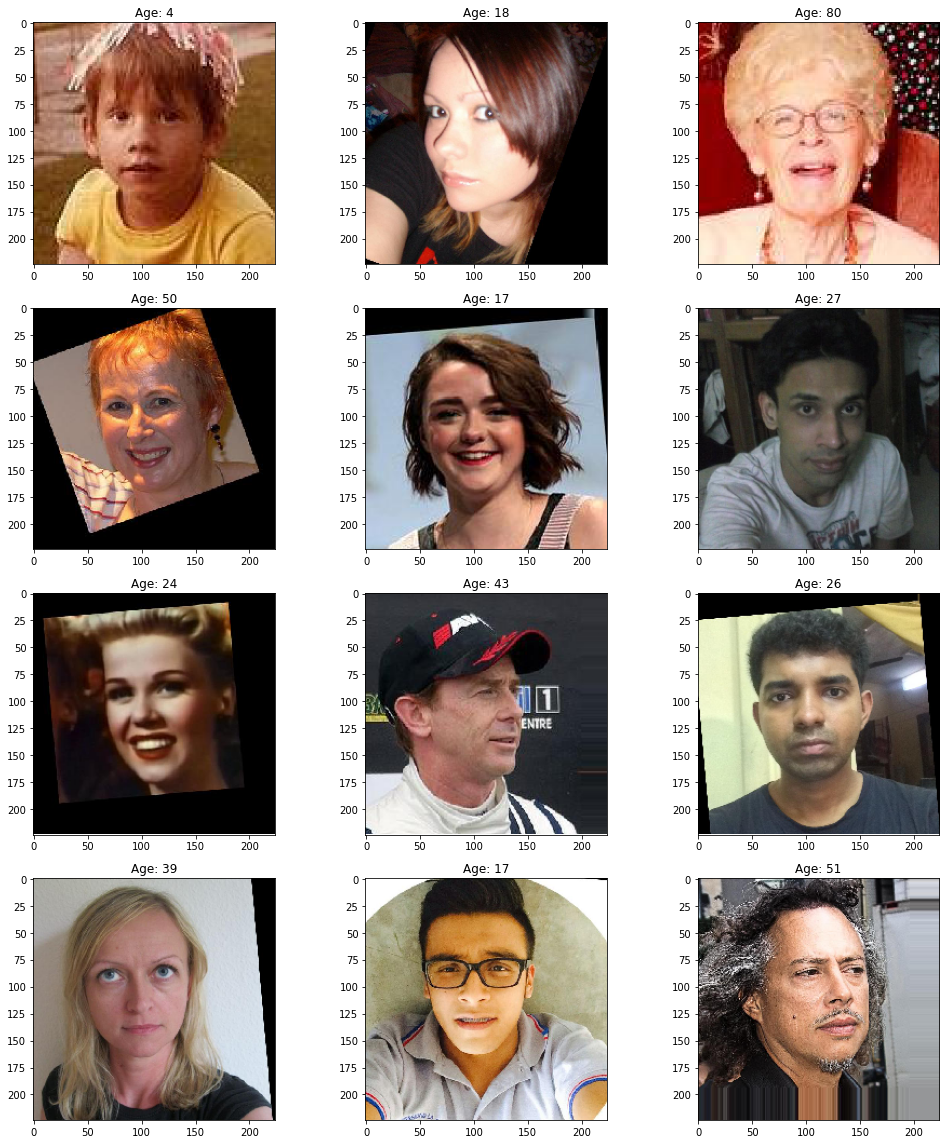

In [20]:
# выводим 16 изображений для предварительного обзора

fig = plt.figure(figsize=(16,16))
for i in range(12):
    fig.add_subplot(4, 3, i+1).set_title(f'Age: {data.real_age[i]}')
    plt.imshow(features[i])  
    plt.tight_layout() 

**Вывод:** 

- ориентация фотографий правильная, поворачивать их не нужно;
- все фотографии цветные;
- размер изображений приведен к значению 224 х 224.

## 2.2 Таблица

**Обзор**

In [7]:
display(data)
print()
data.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Пропуски**

In [8]:
# функция построения гистограммы пропусков

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(15, 6), legend=False, fontsize=15)
            .set_title('Гистограмма пропусков' + "\n", fontsize=22, color='SteelBlue')    
        );   
        print('\nДоля пропусков: {:.2%}'.format(data.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков не осталось 😎')

In [9]:
pass_value_barh(data)

Пропусков не осталось 😎


**Дубликаты**

In [10]:
print('Кол-во явных дубликатов:', data.duplicated().sum())

Кол-во явных дубликатов: 0


**Целевой признак**

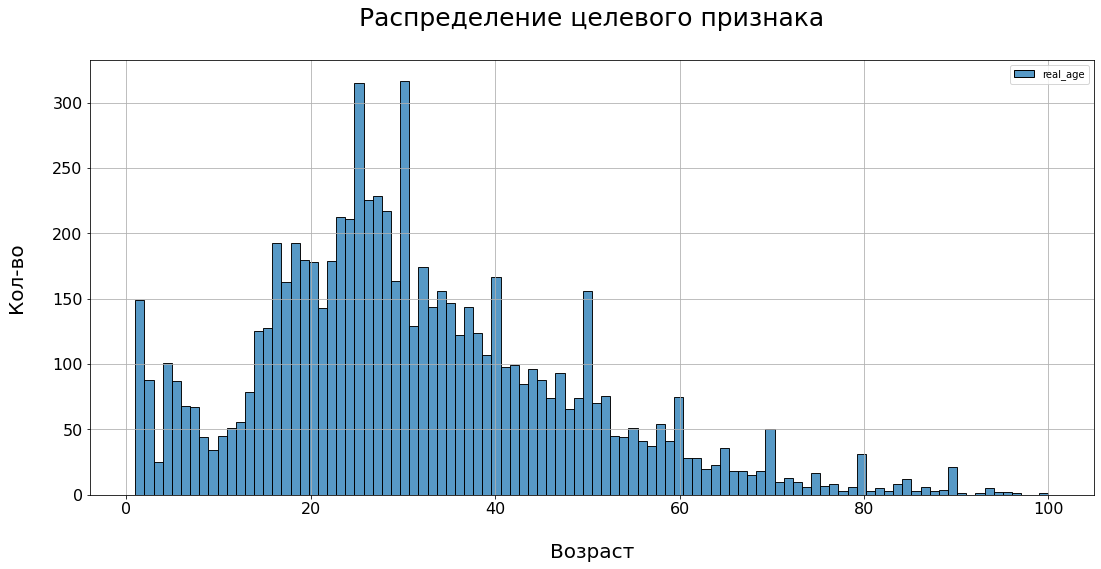

In [11]:
fig1 = plt.figure(figsize=(18, 8))
sns.histplot(data=data, bins=100)
plt.title('Распределение целевого признака\n', fontsize=25)
plt.xlabel('\nВозраст', fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.ylabel('Кол-во\n', fontsize=20, labelpad=20)
plt.yticks(fontsize=16)
plt.grid('on')
plt.show()

In [12]:
data.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

**Вывод:**

- данные состоят из 1 таблицы размером 7591 × 2 и директории с файлами картинок;  
- тип данных объектовый и целочисленный;
- пропусков в данных нет;
- явных дубликатов в данных нет;
- аномалии отсутствуют;
- средний возраст - 31 год;
- имеется выброс на значении 1 - возможно это большое кол-во фотографий детей;
- пики расположены в районе "юбилейных" лет.

# 3 Обучение модели

```python

def load_train(path):
    '''Загружает тренировочный датасет'''
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                    vertical_flip=False, horizontal_flip=False,
                                    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
      labels,
      directory=path + 'final_files/',    # папка, в которой хранится датасет
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),             # к какому размеру приводить изображения  
      batch_size=32,                      # размер батча
      class_mode='raw',                   # в каком виде выдавать метки классов
      subset='training',
      seed=12345
    )
      
    return train_datagen_flow



def load_test(path):
    '''Загружает тестовый датасет'''
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
      labels,
      directory=path + 'final_files/',   # папка, в которой хранится датасет
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),            # к какому размеру приводить изображения  
      batch_size=32,                     # размер батча
      class_mode='raw',                  # в каком виде выдавать метки классов
      subset='validation',
      seed=12345)
      
    return test_datagen_flow



def create_model(input_shape):
    '''Создает модель ResNet50'''
    
    # основа сети на базе ResNet50
    backbone = ResNet50(input_shape=input_shape,   # размер входного изображения 
                        weights='imagenet',        # инициализация весов. Используем модель, предобученную на 'imagenet'
                        include_top=False)         # 2 последних слоя сети (GlobalAveragePooling2D и Dense) исключаем
    
    # оптимайзер обучения сети
    optimizer = Adam(lr=0.0001)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())            # пулинг слой с окном во весь тензор, среднее значение
    model.add(Dense(1, activation='relu'))         # полносвязный слой с Relu-активацией для регрессии
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    '''Обучает модель'''
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 

```

> **Примечание.** Код из этого раздела запускается на отдельном GPU-сервере. Поэтому резульат вывода на экран оформлен как код в текстовой ячейке.

**Результат работы сети при запуске на GPU-сервере:**

```


Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-04-21 10:11:25.437325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-21 10:11:25.805385: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 54s - loss: 239.1995 - mae: 11.0538 - val_loss: 1032.7709 - val_mae: 27.4817
Epoch 2/10
178/178 - 49s - loss: 61.3820 - mae: 5.9110 - val_loss: 999.6571 - val_mae: 26.9505
Epoch 3/10
178/178 - 50s - loss: 29.5139 - mae: 4.2039 - val_loss: 326.4142 - val_mae: 13.4215
Epoch 4/10
178/178 - 42s - loss: 19.8569 - mae: 3.4331 - val_loss: 113.5487 - val_mae: 8.1811
Epoch 5/10
Epoch 6/10
178/178 - 47s - loss: 15.7397 - mae: 3.0750 - val_loss: 101.8932 - val_mae: 7.6745
178/178 - 50s - loss: 13.0917 - mae: 2.7794 - val_loss: 72.0058 - val_mae: 6.5865
Epoch 7/10
178/178 - 49s - loss: 10.2953 - mae: 2.4510 - val_loss: 70.1001 - val_mae: 6.2707
Epoch 8/10
178/178 - 42s - loss: 9.3856 - mae: 2.3142 - val_loss: 64.2286 - val_mae: 6.1033
Epoch 9/10
178/178 - 49s - loss: 8.6742 - mae: 2.2042 - val_loss: 70.8877 - val_mae: 6.4251
Epoch 10/10
178/178 - 50s - loss: 7.7401 - mae: 2.1104 - val_loss: 65.2363 - val_mae: 6.0981
WARNING:tensorflow:sample_weight modes were coerced from
60/60 - 11s - loss: 65.2363 - mae: 6.0981
Test MAE: 6.0981



```

# 4 Вывод по проекту

В ходе выполнения проекта была построена модель, определяющая по фотографии приблизительный возраст человека. 

Модель построена на основе архитектуры свёрточной нейросети ResNet50, предобученная на датасете ImageNet:

- два последних слоя модели заморожены, а вместо них добавлены новые:
    - первый слой GlobalAveragePooling2D — пулинг с окном во весь тензор, чтобы получить пиксель с большим количеством каналов
    - второй слой Dense — полносвязный слой с одним нейроном и Relu активацией для задачи регрессии
- модель обучена на 10 эпохах
- дополнительных преобразований изображений не проводилось

На тестовой выборке метрика **MAE** модели равна **6.0981**.

Для улучшения качества модели, судя по распределению целевого признака, отличным решением будет дополнить выборку фотографиями людей старше 41 года.